# DATASETS & DATALOADERS

In [12]:
import torch 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# 1. Preloaded Datasest

## 1. Download Data 

In [13]:
training_data = datasets.FashionMNIST(
    root = "data", 
    train = True,
    download = True,
    transform = ToTensor()
)

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [14]:
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download=True,
    transform=ToTensor()
)

## 2. Iterating and Visualizing the Dataset

In [16]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

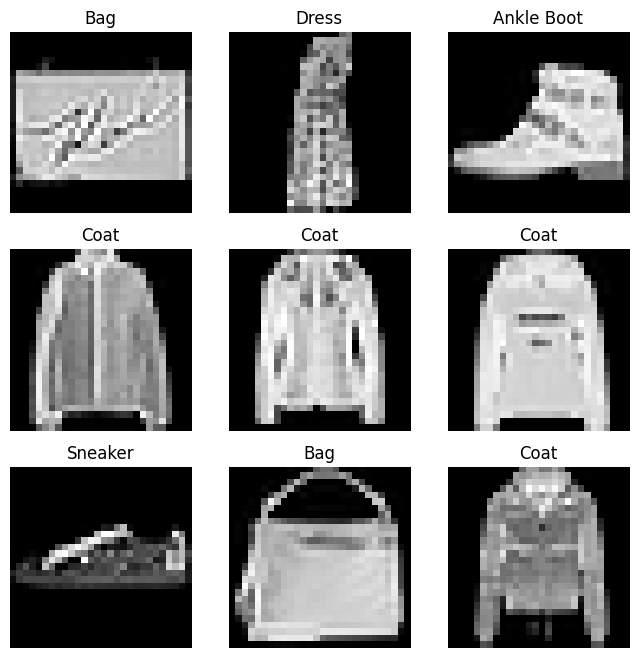

In [63]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# 2. Creating a Custom Dataset for your files

In [64]:
import os 
import pandas as pd
from torchvision.io import read_image

In [65]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# 3. DataLoaders 

In [75]:
from torch.utils.data import DataLoader

In [76]:
train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [77]:
train_dataloader

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


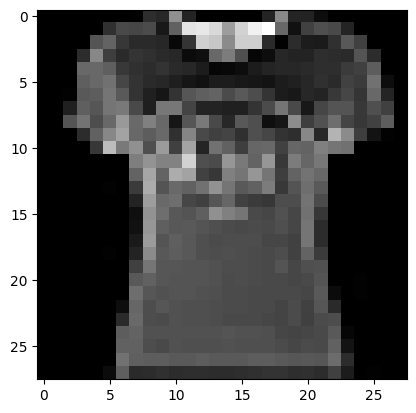

Label: 0


In [93]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# 

# Transfroms

All TorchVision datasets have two parameters 
- `transform` to modify the features and 
- `target_transform` to modify the labels 

that accept callables containing the transformation logic.

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

In [2]:
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [3]:
ds

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Target transform: Lambda()


### `ToTensor()`
ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]

### `Lambda Transforms`
Lambda transforms apply any user-defined lambda function. Here, we define a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter_ which assigns a value=1 on the index as given by the label y.

# Build Model

In [4]:
import os 
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Setting up the GPU 

In [5]:
device = (
    "cude"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# `Defining the nn class`

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [13]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [14]:
X = torch.rand(1, 28, 28, device = device)
logits = model(X)

In [17]:
pred_prob = nn.Softmax(dim=1)(logits)

In [19]:
y_pred = pred_prob.argmax(1)

In [20]:
print(f"Predicted class: {y_pred}")

Predicted class: tensor([0])


# Model Layer

In [21]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


In [22]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


In [23]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


In [24]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.3062, -0.2287, -0.1453, -0.4720,  0.6017, -0.0102,  0.2382,  0.3650,
          0.0998,  0.2104,  0.7823,  0.3146, -0.3851,  0.5649, -0.2046, -0.2105,
          0.8043,  0.2264,  0.4634,  0.7431],
        [ 0.1427, -0.1028,  0.2168, -0.3601,  0.0243,  0.2852,  0.4200,  0.0400,
          0.0014, -0.0577,  0.4002,  0.1625, -0.1127,  0.3939, -0.1369, -0.0497,
          0.5567,  0.5203, -0.0491,  0.6466],
        [ 0.1598, -0.1616, -0.1270, -0.3993,  0.2750,  0.0914,  0.7204,  0.1636,
          0.3605, -0.2658,  0.6481, -0.1783, -0.2992,  0.7172, -0.2122, -0.1741,
          0.6300,  0.2364, -0.0842,  0.3850]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.3062, 0.0000, 0.0000, 0.0000, 0.6017, 0.0000, 0.2382, 0.3650, 0.0998,
         0.2104, 0.7823, 0.3146, 0.0000, 0.5649, 0.0000, 0.0000, 0.8043, 0.2264,
         0.4634, 0.7431],
        [0.1427, 0.0000, 0.2168, 0.0000, 0.0243, 0.2852, 0.4200, 0.0400, 0.0014,
         0.0000, 0.4002, 0.1625, 0.0000, 0.3939, 0.00

In [25]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

In [26]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [27]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0190,  0.0283,  0.0129,  ..., -0.0348, -0.0032, -0.0135],
        [-0.0209,  0.0072,  0.0050,  ...,  0.0017,  0.0321, -0.0195]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([0.0155, 0.0292], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0368, -0.0208,  0.0321,  ..., -0.0233, -0.0227, -0.0086],
        [ 0.0175,  0.0422, -0.0246,  ...,  0.0276, -0.0130,  0.0234]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Si

# AutoGrad

In [42]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

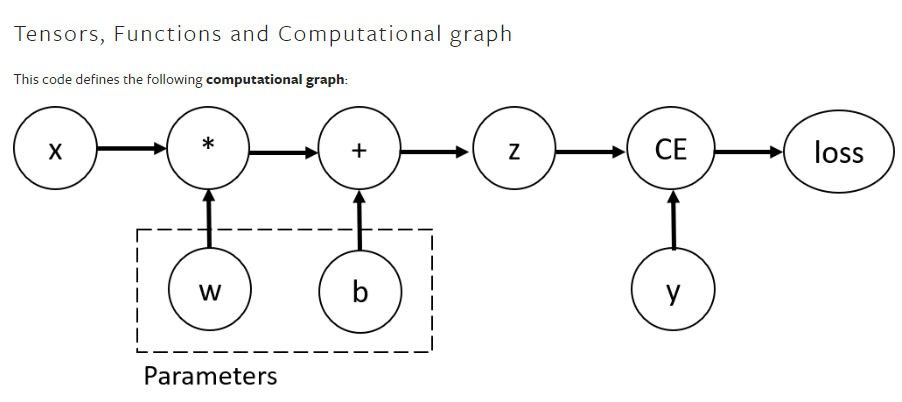

In this network, w and b are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the requires_grad property of those tensors.

In [43]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x00000273BF134C70>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x00000273BF134F70>


In [44]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.3092, 0.3087, 0.1011],
        [0.3092, 0.3087, 0.1011],
        [0.3092, 0.3087, 0.1011],
        [0.3092, 0.3087, 0.1011],
        [0.3092, 0.3087, 0.1011]])
tensor([0.3092, 0.3087, 0.1011])


In [45]:
with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

False


In [46]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

z_det = z.detach()
print(z_det.requires_grad)

True
False


There are reasons you might want to disable gradient tracking:
- To mark some parameters in your neural network as frozen parameters.
- To speed up computations when you are only doing forward pass, because computations on tensors that do not track gradients would be more efficient.

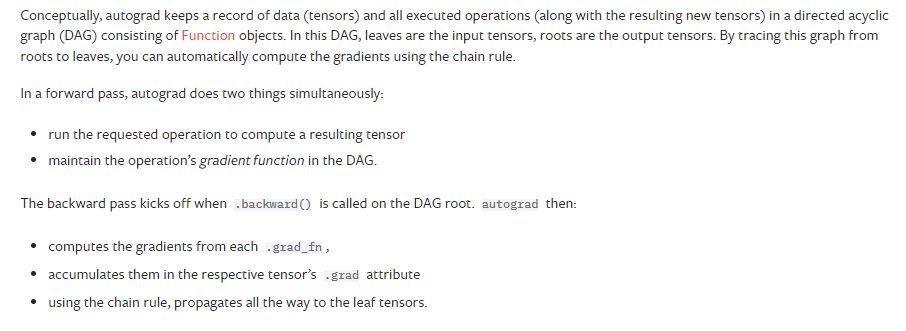